In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# For balancing


# For explainability
import shap

# Step 2: Load dataset
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
print("Dataset shape:", df.shape)

# Step 3: Basic info and inspection
print(df.info())
print(df.head())
print(df['Diabetes_binary'].value_counts())


Dataset shape: (253680, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               25

In [2]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check data types
print(df.dtypes)

# Describe numeric columns to check for outliers or strange values
print(df.describe())

# Optionally rename columns for better readability (if needed)
df.rename(columns={'Diabetes_binary': 'Diabetic'}, inplace=True)

# Check unique values of categorical features (if any)
for col in df.columns:
    if df[col].dtype == 'int64' and df[col].nunique() < 10:
        print(f"Unique values in {col}: {df[col].unique()}")

# For this dataset, all features are numeric/binary indicators or scaled numeric
# Check if any column has only one value (no variance)
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"Column with only one unique value: {col}")


Missing values per column:
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Duplicate rows: 24206
Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholCons

In [3]:
# Drop duplicate rows
print(f"Shape before dropping duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after dropping duplicates: {df.shape}")

# Convert binary float columns to int
binary_cols = [col for col in df.columns if set(df[col].unique()) <= {0.0, 1.0}]
df[binary_cols] = df[binary_cols].astype(int)

# Check again info and datatypes
print(df.info())


Shape before dropping duplicates: (253680, 22)
Shape after dropping duplicates: (229474, 22)
<class 'pandas.core.frame.DataFrame'>
Index: 229474 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetic              229474 non-null  int32  
 1   HighBP                229474 non-null  int32  
 2   HighChol              229474 non-null  int32  
 3   CholCheck             229474 non-null  int32  
 4   BMI                   229474 non-null  float64
 5   Smoker                229474 non-null  int32  
 6   Stroke                229474 non-null  int32  
 7   HeartDiseaseorAttack  229474 non-null  int32  
 8   PhysActivity          229474 non-null  int32  
 9   Fruits                229474 non-null  int32  
 10  Veggies               229474 non-null  int32  
 11  HvyAlcoholConsump     229474 non-null  int32  
 12  AnyHealthcare         229474 non-null  int32  
 13  NoDocbcCost     

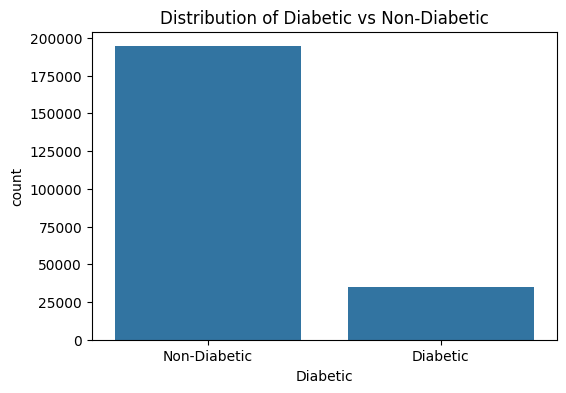

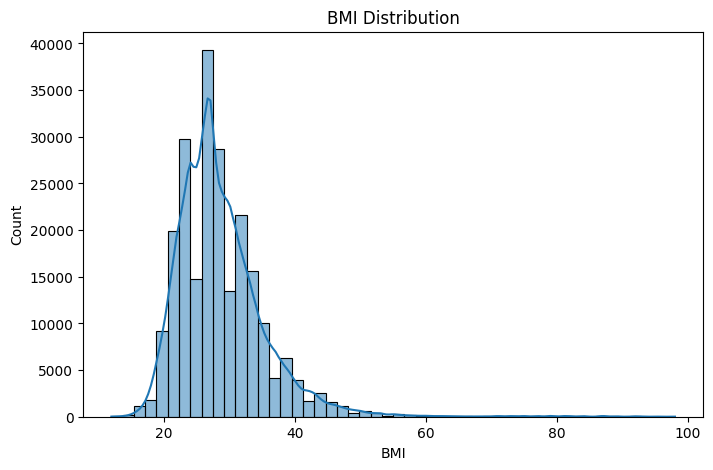

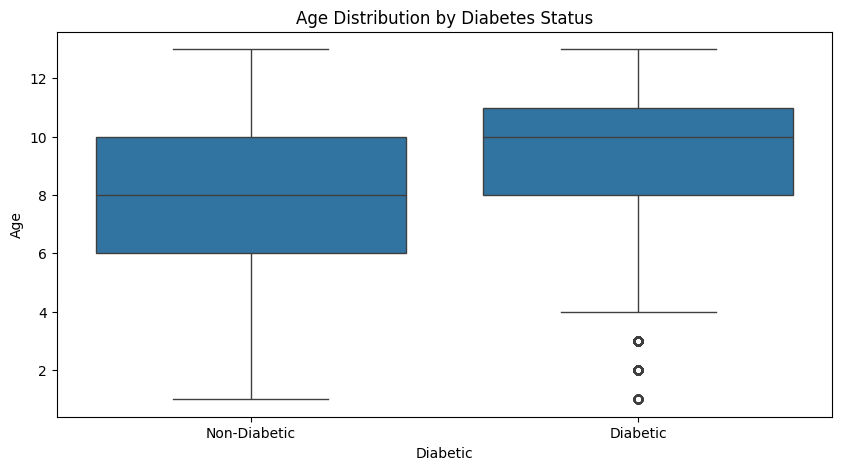

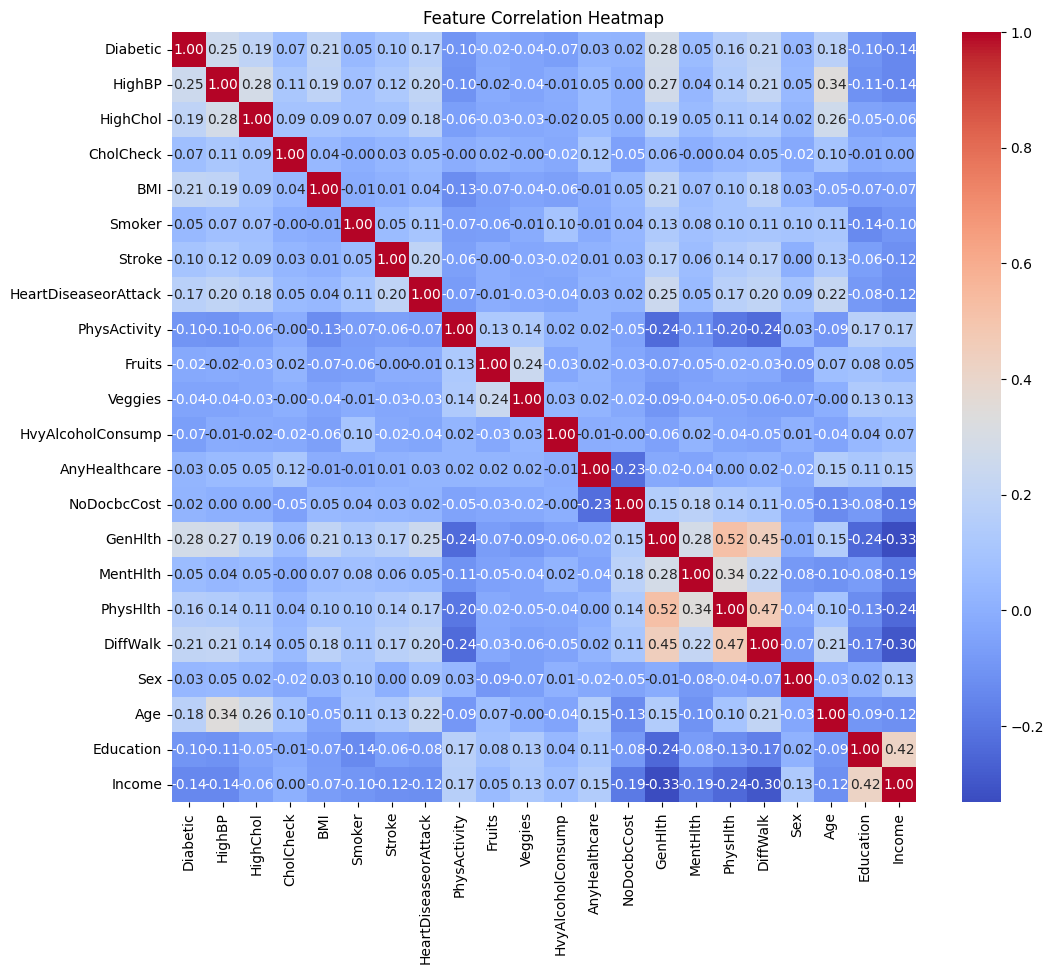

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Target Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Diabetic', data=df)
plt.title('Distribution of Diabetic vs Non-Diabetic')
plt.xticks([0,1], ['Non-Diabetic', 'Diabetic'])
plt.show()

# 2. Histogram of BMI
plt.figure(figsize=(8,5))
sns.histplot(df['BMI'], bins=50, kde=True)
plt.title('BMI Distribution')
plt.show()

# 3. Boxplot for Age groups vs Diabetes
plt.figure(figsize=(10,5))
sns.boxplot(x='Diabetic', y='Age', data=df)
plt.title('Age Distribution by Diabetes Status')
plt.xticks([0,1], ['Non-Diabetic', 'Diabetic'])
plt.show()

# 4. Correlation heatmap of features (only numeric)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [5]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Assuming your dataframe is named df and target column is 'Diabetic'
X = df.drop('Diabetic', axis=1)
y = df['Diabetic']

# 1. Split data into training and test sets (stratify to keep class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Before balancing:")
print(y_train.value_counts())

# 2. Apply SMOTE + Tomek Links only on training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("\nAfter balancing:")
print(y_train_resampled.value_counts())

# Now, X_train_resampled and y_train_resampled are balanced and ready for model training
# X_test and y_test remain untouched for evaluation


Before balancing:
Diabetic
0    155501
1     28078
Name: count, dtype: int64

After balancing:
Diabetic
0    155382
1    155382
Name: count, dtype: int64


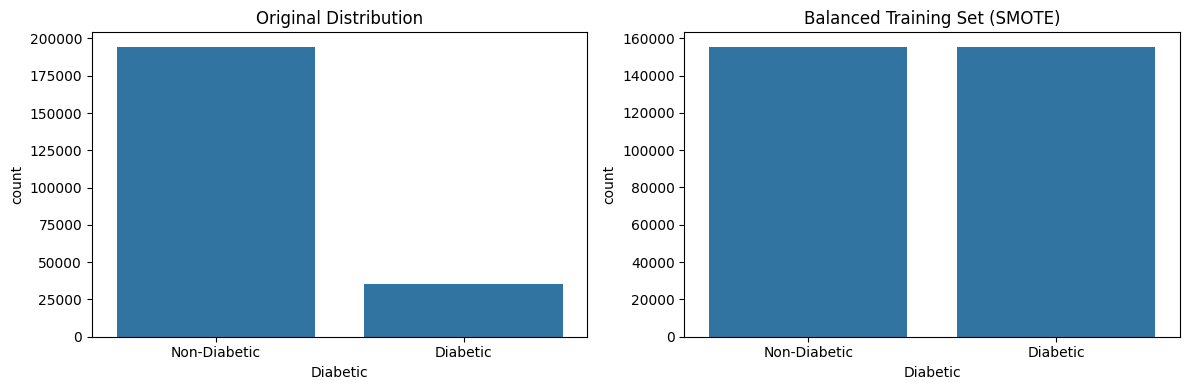

In [7]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original imbalanced data
sns.countplot(x='Diabetic', data=df, ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'])

# SMOTE-balanced data
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title('Balanced Training Set (SMOTE)')
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['Non-Diabetic', 'Diabetic'])

plt.tight_layout()
plt.show()


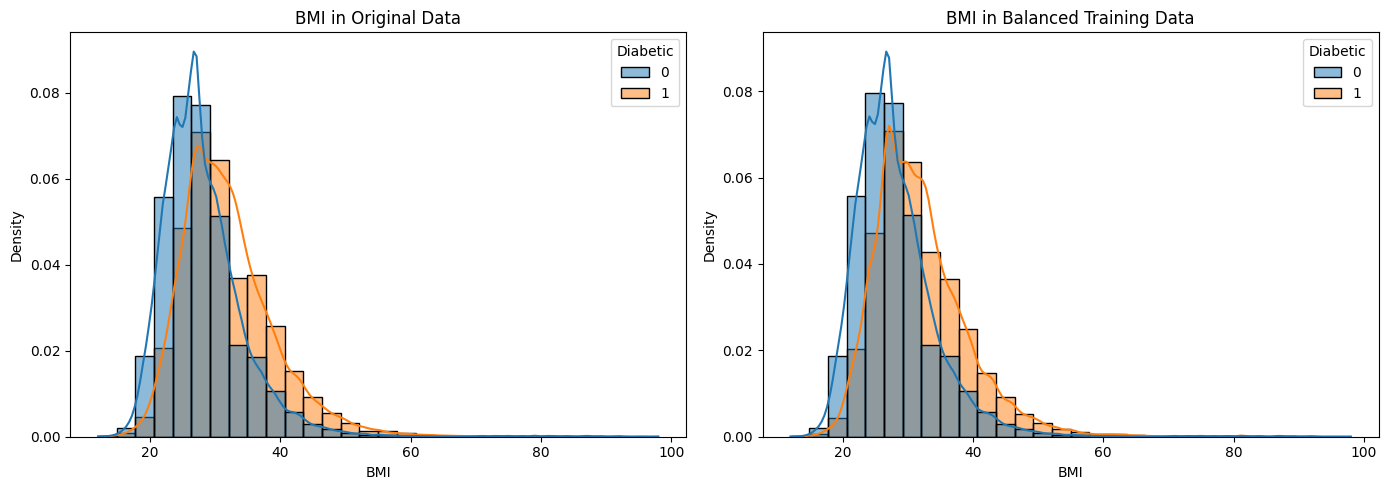

In [8]:
# Combine back into DataFrames for plotting
train_bal = pd.DataFrame(X_train_resampled, columns=X.columns)
train_bal['Diabetic'] = y_train_resampled

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(data=df, x='BMI', hue='Diabetic', kde=True, stat='density',
             common_norm=False, bins=30, ax=axes[0])
axes[0].set_title('BMI in Original Data')

sns.histplot(data=train_bal, x='BMI', hue='Diabetic', kde=True, stat='density',
             common_norm=False, bins=30, ax=axes[1])
axes[1].set_title('BMI in Balanced Training Data')

plt.tight_layout()
plt.show()


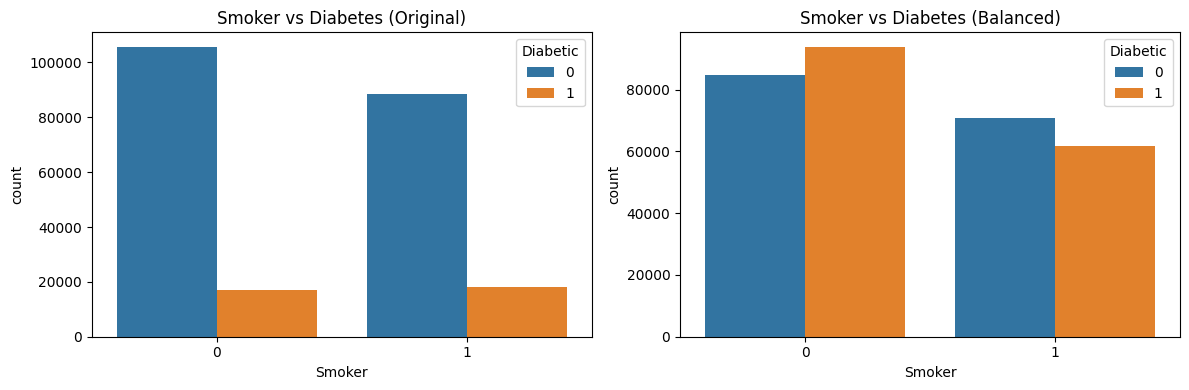

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x='Smoker', hue='Diabetic', data=df, ax=axes[0])
axes[0].set_title('Smoker vs Diabetes (Original)')

sns.countplot(x='Smoker', hue='Diabetic', data=train_bal, ax=axes[1])
axes[1].set_title('Smoker vs Diabetes (Balanced)')

plt.tight_layout()
plt.show()


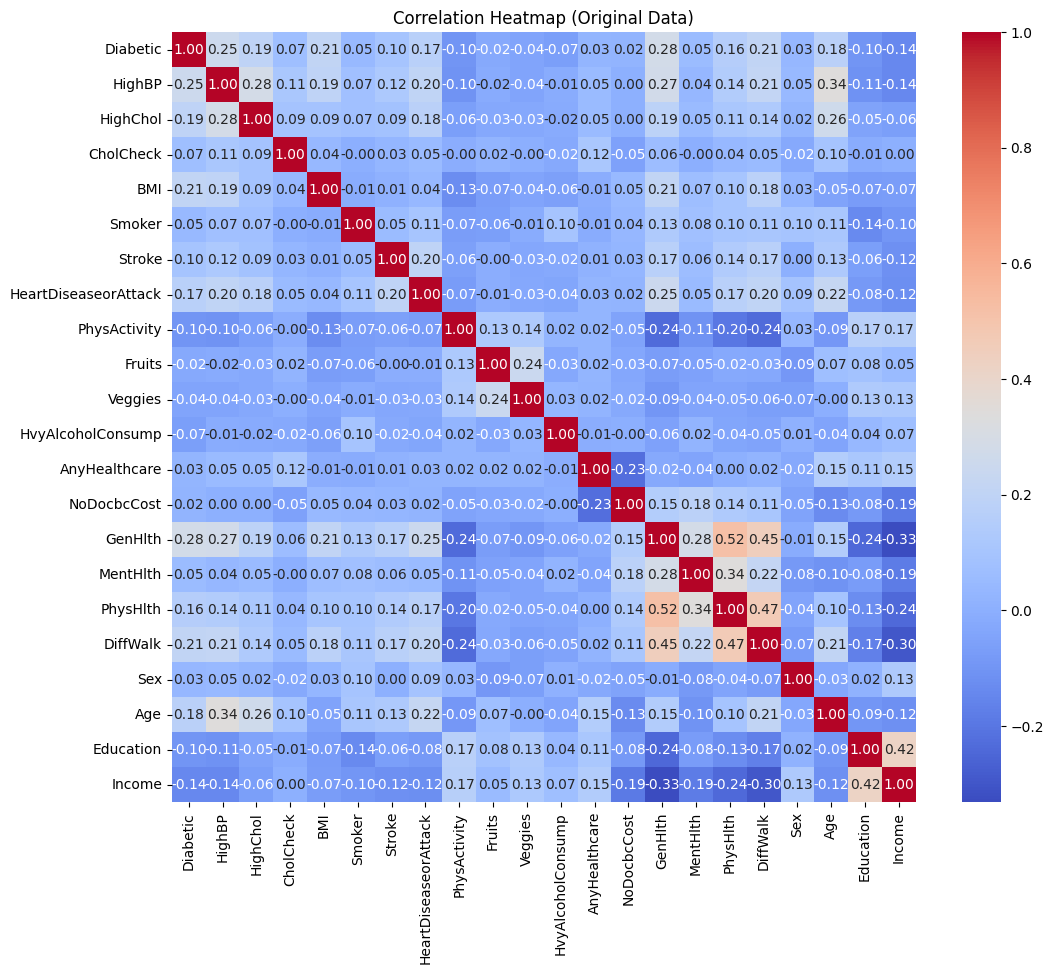

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Original Data)")
plt.show()

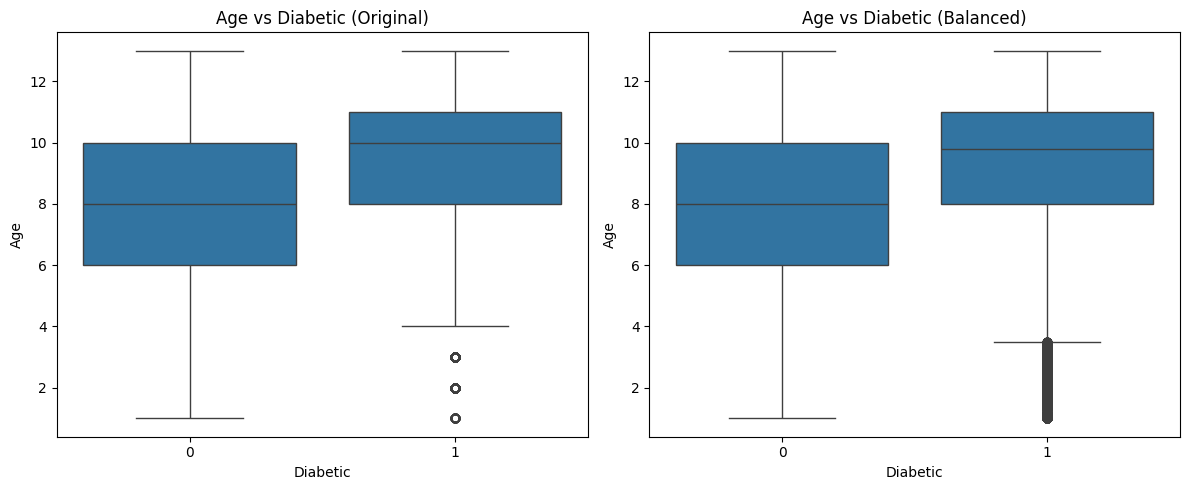

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='Diabetic', y='Age', data=df, ax=axes[0])
axes[0].set_title('Age vs Diabetic (Original)')

sns.boxplot(x='Diabetic', y='Age', data=train_bal, ax=axes[1])
axes[1].set_title('Age vs Diabetic (Balanced)')

plt.tight_layout()
plt.show()


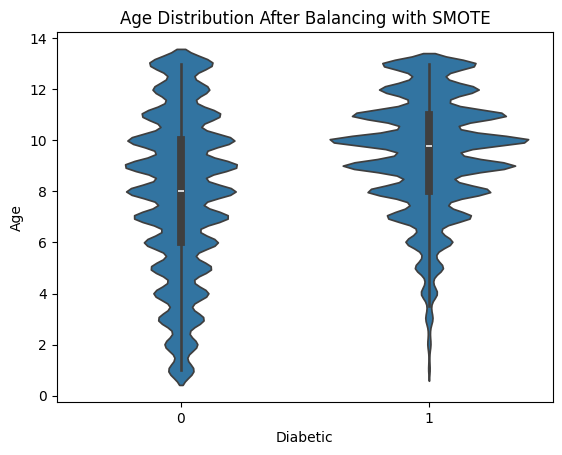

In [12]:
sns.violinplot(x='Diabetic', y='Age', data=train_bal)
plt.title("Age Distribution After Balancing with SMOTE")
plt.show()

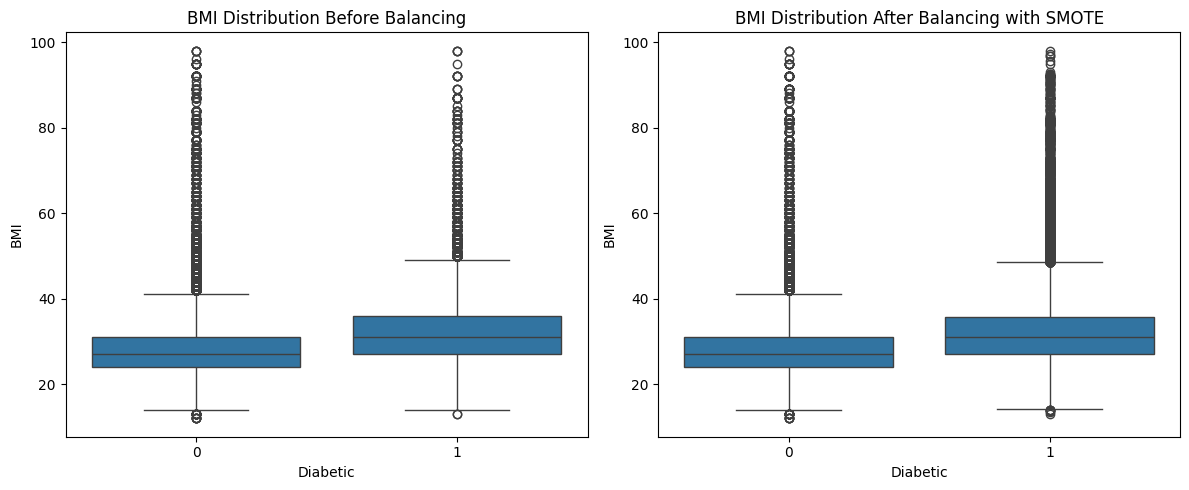

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='Diabetic', y='BMI', data=df)
plt.title('BMI Distribution Before Balancing')

plt.subplot(1,2,2)
sns.boxplot(x='Diabetic', y='BMI', data=train_bal)  # balanced data
plt.title('BMI Distribution After Balancing with SMOTE')

plt.tight_layout()
plt.show()

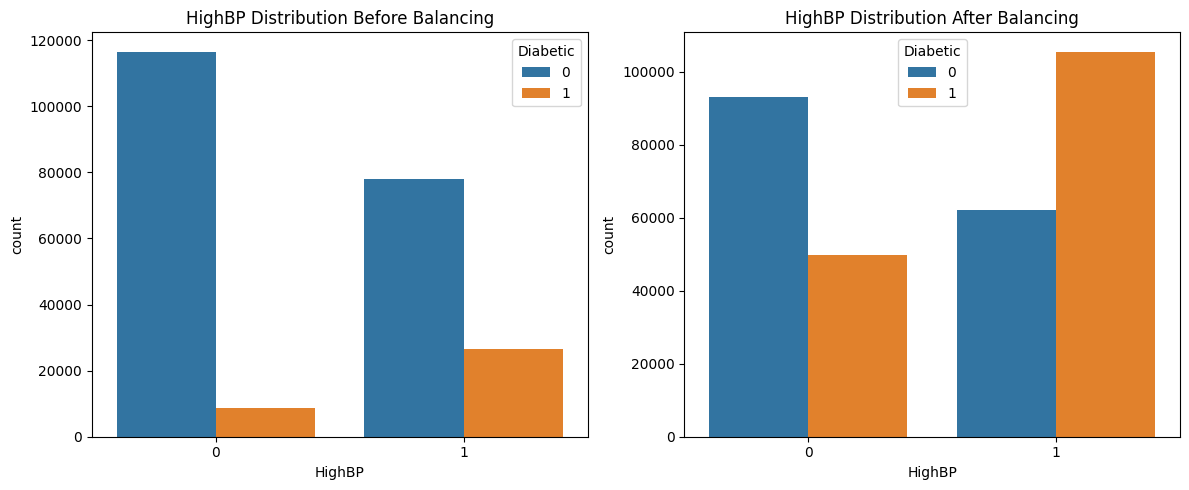

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='HighBP', hue='Diabetic', data=df)
plt.title('HighBP Distribution Before Balancing')

plt.subplot(1,2,2)
sns.countplot(x='HighBP', hue='Diabetic', data=train_bal)
plt.title('HighBP Distribution After Balancing')

plt.tight_layout()
plt.show()


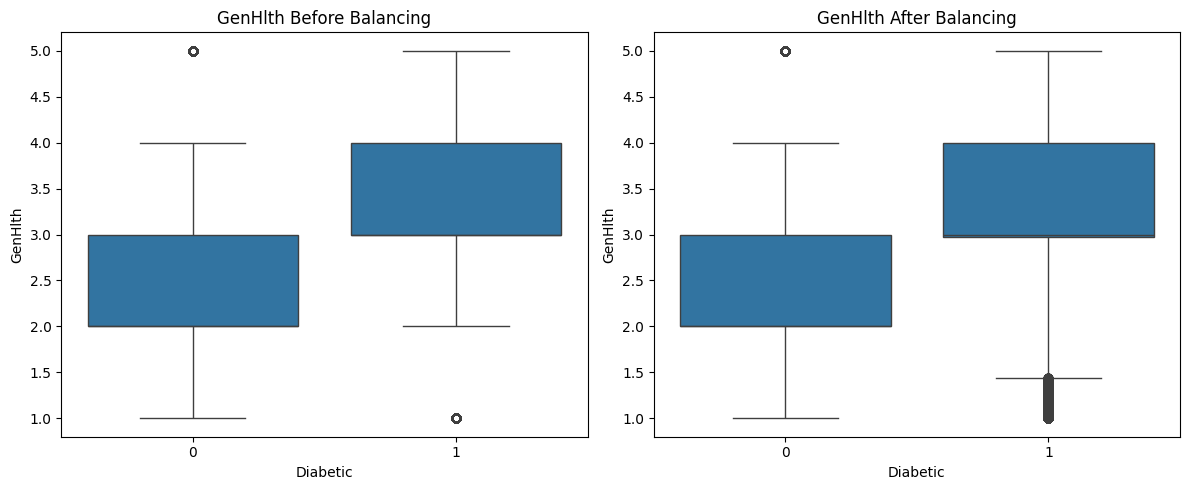

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='Diabetic', y='GenHlth', data=df)
plt.title('GenHlth Before Balancing')

plt.subplot(1,2,2)
sns.boxplot(x='Diabetic', y='GenHlth', data=train_bal)
plt.title('GenHlth After Balancing')

plt.tight_layout()
plt.show()

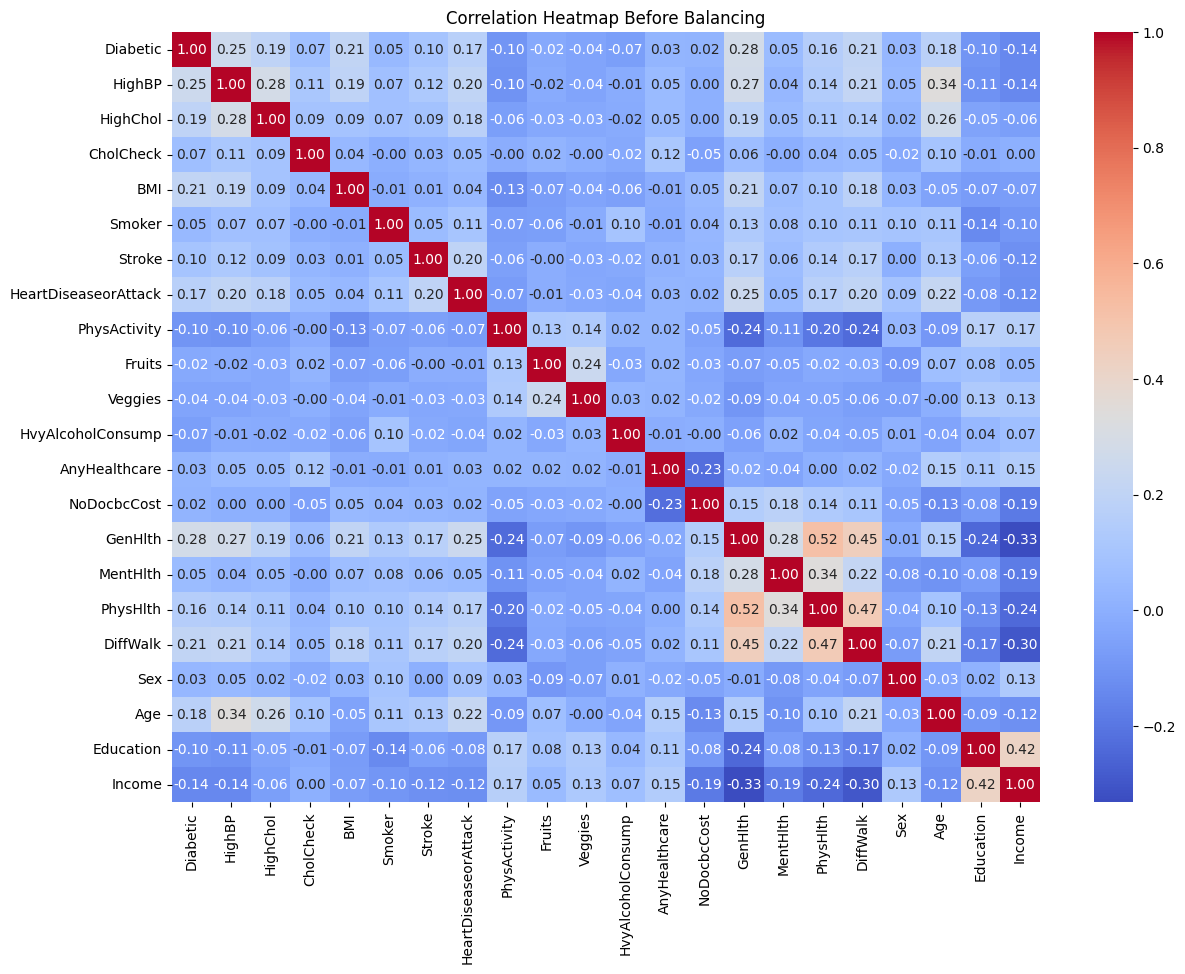

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap Before Balancing')
plt.show()

In [22]:
import pandas as pd
import numpy as np

# Age bins (example based on typical age groups)
age_bins = [0, 2, 5, 8, 10, 13, 15]  # According to your Age feature scale (1-13)
age_labels = ['Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior', 'Elder']

df['Age_group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# For balanced dataset as well
train_bal['Age_group'] = pd.cut(train_bal['Age'], bins=age_bins, labels=age_labels, right=False)

# BMI bins (WHO classification for adults)
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

df['BMI_category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)
train_bal['BMI_category'] = pd.cut(train_bal['BMI'], bins=bmi_bins, labels=bmi_labels)


In [23]:
risk_factors = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'DiffWalk']

df['RiskFactorCount'] = df[risk_factors].sum(axis=1)
train_bal['RiskFactorCount'] = train_bal[risk_factors].sum(axis=1)


In [24]:
# Numeric encoding
df['Age_group_code'] = df['Age_group'].cat.codes
df['BMI_category_code'] = df['BMI_category'].cat.codes

train_bal['Age_group_code'] = train_bal['Age_group'].cat.codes
train_bal['BMI_category_code'] = train_bal['BMI_category'].cat.codes

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', ]

# Fit scaler on training balanced data and transform both datasets
train_bal[num_cols] = scaler.fit_transform(train_bal[num_cols])
df[num_cols] = scaler.transform(df[num_cols])  # Use the same scaler to transform original df for consistency

In [17]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train_bal.drop(columns=['Diabetic', 'Age_group', 'BMI_category'])  # drop target and original categorical columns
y = train_bal['Diabetic']

# Split 80% train, 20% test (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (248611, 24)
Test set shape: (62153, 24)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict on test
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     31077
           1       0.90      0.90      0.90     31076

    accuracy                           0.90     62153
   macro avg       0.90      0.90      0.90     62153
weighted avg       0.90      0.90      0.90     62153

ROC AUC Score: 0.9653471402728626


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     31077
           1       0.90      0.90      0.90     31076

    accuracy                           0.90     62153
   macro avg       0.90      0.90      0.90     62153
weighted avg       0.90      0.90      0.90     62153

ROC AUC Score: 0.9653471402728626
Accuracy: 0.9008


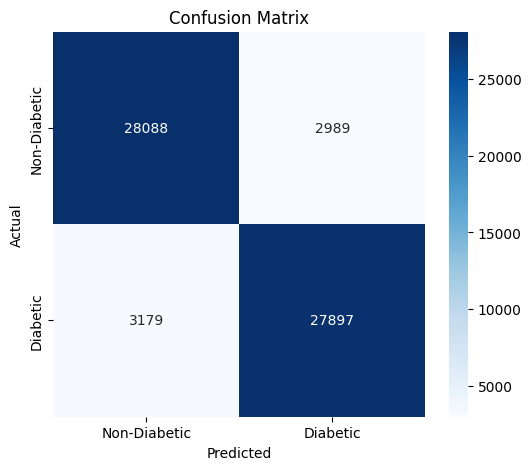

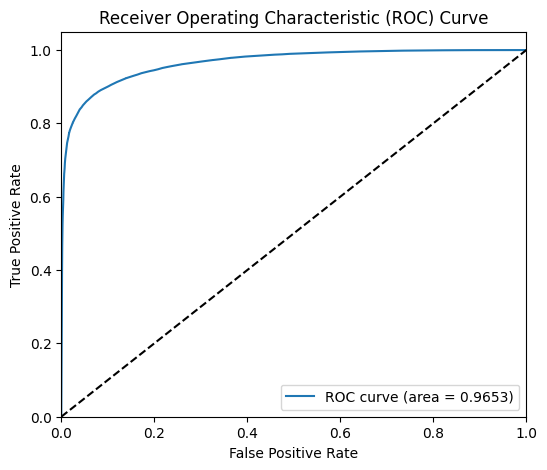

In [19]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report and ROC AUC (you already have this)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
# just for verifying  
import numpy as np
print("Class distribution in training data:")
print(np.bincount(y_train))

Class distribution in training data:
[124305 124306]


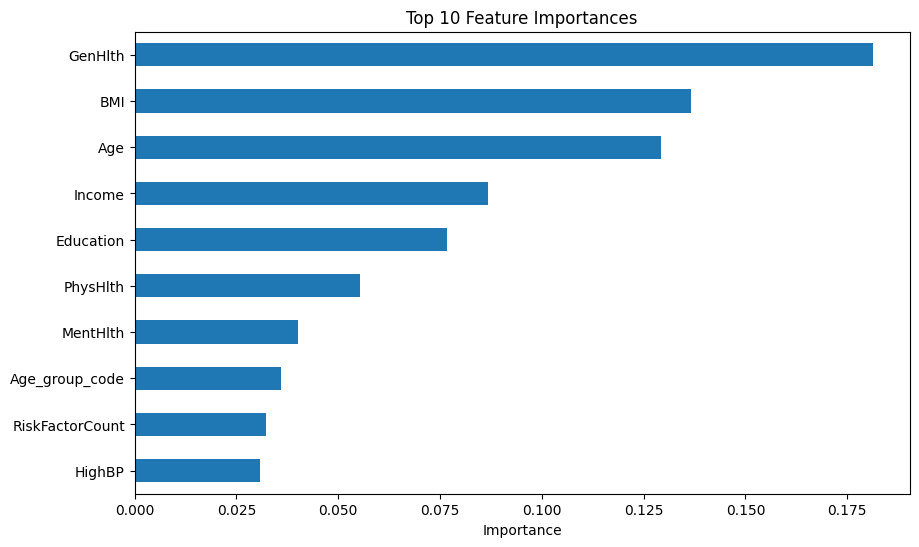

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming X_train is your training features DataFrame

# Get feature importances from the model
importances = rf.feature_importances_

# Create a pandas Series for easy plotting and sorting
feat_importances = pd.Series(importances, index=X_train.columns)

# Sort descending
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
feat_importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.show()


In [6]:
## tried using 4features later scrapped...just for reference 
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

features = ['HighBP', 'BMI', 'Age', 'Smoker']

# Split data (stratify to maintain label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df['Diabetic'], test_size=0.2, random_state=42, stratify=df['Diabetic']
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Save model
joblib.dump(rf, 'diabetes_rf_model_4features.joblib')

print("Model trained and saved successfully!")


Model trained and saved successfully!


In [29]:
features = ['HighBP', 'BMI', 'Age', 'Smoker']

# Use balanced data DataFrame, for example `train_bal`
X_train_bal = train_bal[features]
y_train_bal = train_bal['Diabetic']

# Check lengths
print(len(X_train_bal), len(y_train_bal))  # should be equal

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale features
X_train_scaled = scaler.fit_transform(X_train_bal)

# Train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_bal)

# Save scaler and model
import joblib
joblib.dump(scaler, 'scaler_4features.joblib')
joblib.dump(rf, 'diabetes_rf_model_4features.joblib')


310764 310764


['diabetes_rf_model_4features.joblib']

In [30]:
## tried using 4features later considered...just for reference
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

# Load your dataset
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')  # Replace with your file name

# Define top features based on importance
top_features = ['GenHlth', 'BMI', 'Age', 'Income', 'Education', 'PhysHlth', 'MentHlth', 'HighBP']
X = df[top_features]
y = df['Diabetes_binary']  # 

# Train-test split (before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Save model and scaler
joblib.dump(rf, 'diabetes_rf_model_top.joblib')
joblib.dump(scaler, 'scaler_top.joblib')

print("Model trained on top 8 features with balanced data and saved successfully.")


Model trained on top 8 features with balanced data and saved successfully.


In [31]:
# Same numeric columns used for scaling
numeric_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
scaler = StandardScaler()
train_bal[numeric_cols] = scaler.fit_transform(train_bal[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Save for later use in app
import joblib
joblib.dump(scaler, "scaler.joblib")
joblib.dump(numeric_cols, "numeric_cols.joblib")
joblib.dump(list(X.columns), "model_features.joblib")
joblib.dump(rf, "diabetes_rf_model.joblib")


['diabetes_rf_model.joblib']

In [34]:
# Load dataset once
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# Filter low risk samples (non-diabetic, low BMI, good health)
low_risk = df[(df['Diabetes_binary'] == 0) & (df['BMI'] < 25) & (df['GenHlth'] <= 2)]
print("Low-risk samples in dataset:", len(low_risk))

# Just sanity: how many diabetics in this subset? Should be 0 since Diabetes_binary == 0 filtered
print("Diabetic samples in low-risk subset:", low_risk['Diabetes_binary'].sum())

# If you want to check how many samples in dataset have diabetes overall:
print("Total diabetic samples in dataset:", df['Diabetes_binary'].sum())


Low-risk samples in dataset: 45561
Diabetic samples in low-risk subset: 0.0
Total diabetic samples in dataset: 35346.0


In [35]:
print(scaler.feature_names_in_)


['BMI' 'GenHlth' 'MentHlth' 'PhysHlth' 'Age' 'Education' 'Income']


In [38]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load dataset
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# 2. Feature engineering
risk_factors = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'DiffWalk']
df['RiskFactorCount'] = df[risk_factors].sum(axis=1)

# Age and BMI categorical bins
df['Age_group_code'] = df['Age']  # Already 1 to 13
df['BMI_category_code'] = pd.cut(df['BMI'],
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=[0, 1, 2, 3],
                                 include_lowest=True).astype(int)

# 3. Define features and label
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 4. Apply SMOTE to balance data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_res)

# 6. Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 7. Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# 8. Feature Importance
print("\n=== Feature Importances ===")
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)
print(feat_imp_sorted)

# 9. Save model and feature list
joblib.dump(rf, "revised_diabetes_rf_model.joblib")
joblib.dump(list(X.columns), "revised_model_features.joblib")



=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92     43667
         1.0       0.95      0.88      0.92     43667

    accuracy                           0.92     87334
   macro avg       0.92      0.92      0.92     87334
weighted avg       0.92      0.92      0.92     87334

ROC AUC Score: 0.9718810099180422

=== Feature Importances ===
GenHlth                 0.147130
HighBP                  0.112167
BMI                     0.087865
RiskFactorCount         0.087160
HighChol                0.058015
Income                  0.052814
Age                     0.049009
Age_group_code          0.045845
Education               0.044906
Sex                     0.041550
PhysActivity            0.035081
Fruits                  0.033357
PhysHlth                0.033047
DiffWalk                0.030106
Smoker                  0.025163
MentHlth                0.024638
Veggies                 0.022056
HeartDiseaseorAtta

['revised_model_features.joblib']

In [21]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import sklearn

print(f"Using scikit-learn version: {sklearn.__version__}")

# 1. Load dataset
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# 2. Feature engineering (same as your original)
risk_factors = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'DiffWalk']
df['RiskFactorCount'] = df[risk_factors].sum(axis=1)

# Age and BMI categorical bins
df['Age_group_code'] = df['Age']  # Already 1 to 13
df['BMI_category_code'] = pd.cut(df['BMI'],
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=[0, 1, 2, 3],
                                 include_lowest=True).astype(int)

# 3. Define features and label
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

print(f"Original dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts(normalize=True)}")

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# 6. Train Random Forest model with class balancing
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced',  # This handles class imbalance automatically
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)

print("Training Random Forest model...")
rf.fit(X_train, y_train)

# 7. Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 8. Feature Importance
print("\n=== Top 10 Feature Importances ===")
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)
print(feat_imp_sorted.head(10))

# 9. Save model and feature list
joblib.dump(rf, "revised_diabetes_rf_model.joblib")
joblib.dump(list(X.columns), "revised_model_features.joblib")

print(f"\nModel saved successfully with scikit-learn {sklearn.__version__}!")
print("Files created:")
print("- revised_diabetes_rf_model.joblib")
print("- revised_model_features.joblib")

# 10. Test the saved model
print("\n=== Testing Saved Model ===")
loaded_model = joblib.load("revised_diabetes_rf_model.joblib")
loaded_features = joblib.load("revised_model_features.joblib")

# Verify model works
test_pred = loaded_model.predict(X_test[:5])
print(f"Model loading test successful! Sample predictions: {test_pred}")


Using scikit-learn version: 1.6.1
Original dataset shape: (253680, 24)
Class distribution: Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64
Training Random Forest model...

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     43667
         1.0       0.38      0.52      0.44      7069

    accuracy                           0.81     50736
   macro avg       0.65      0.69      0.66     50736
weighted avg       0.84      0.81      0.83     50736

ROC AUC Score: 0.8127

=== Top 10 Feature Importances ===
GenHlth            0.131294
BMI                0.114673
RiskFactorCount    0.098215
HighBP             0.081497
Age                0.071126
Age_group_code     0.063854
Income             0.061142
PhysHlth           0.055247
MentHlth           0.042223
Education          0.041664
dtype: float64

Model saved successfully with scikit-learn 1.6.1!
Files created:
- revised_diabetes_

In [7]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print(f"Using scikit-learn version: {sklearn.__version__}")

# 1. Load dataset
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
print(f"Original dataset shape: {df.shape}")

# 2. Check original class distribution
print("=== Original Class Distribution ===")
print(df.Diabetes_binary.value_counts())
print(df.Diabetes_binary.value_counts(normalize=True))

# Calculate imbalance ratio
majority_count = df.Diabetes_binary.value_counts().max()
minority_count = df.Diabetes_binary.value_counts().min()
imbalance_ratio = majority_count / minority_count
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# 3. Manual balancing (safer than SMOTE)
df_majority = df[df.Diabetes_binary == 0]
df_minority = df[df.Diabetes_binary == 1]

print(f"\nOriginal counts:")
print(f"Majority class (No Diabetes): {len(df_majority):,}")
print(f"Minority class (Diabetes): {len(df_minority):,}")

# Downsample majority to create balanced dataset
df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

print("\n=== After Balancing ===")
print(df_balanced.Diabetes_binary.value_counts())
print(df_balanced.Diabetes_binary.value_counts(normalize=True))
print(f"Balanced dataset shape: {df_balanced.shape}")

# 4. Feature engineering on balanced data
risk_factors = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'DiffWalk']
df_balanced['RiskFactorCount'] = df_balanced[risk_factors].sum(axis=1)
df_balanced['Age_group_code'] = df_balanced['Age']
df_balanced['BMI_category_code'] = pd.cut(df_balanced['BMI'],
                                         bins=[0, 18.5, 25, 30, 100],
                                         labels=[0, 1, 2, 3],
                                         include_lowest=True).astype(int)

print("\n=== Feature Engineering Summary ===")
print(f"Added RiskFactorCount - Range: {df_balanced['RiskFactorCount'].min()}-{df_balanced['RiskFactorCount'].max()}")
print(f"Added BMI_category_code - Distribution:")
print(df_balanced['BMI_category_code'].value_counts().sort_index())

# 5. Features and target
X = df_balanced.drop(columns=['Diabetes_binary'])
y = df_balanced['Diabetes_binary']

print(f"\nFinal feature set: {X.shape[1]} features")
print("Feature columns:", list(X.columns))

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"\nTrain-Test Split:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training class distribution:")
print(y_train.value_counts(normalize=True))

# 7. Train Random Forest model
print("\n=== Training Random Forest Model ===")
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print(" Model training completed!")
# 8. Model Evaluation
print("\n=== Model Evaluation ===")

# Predictions
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Detailed classification report
print("\n=== Detailed Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (correctly predicted non-diabetic): {cm[0,0]:,}")
print(f"False Positives (incorrectly predicted diabetic): {cm[0,1]:,}")
print(f"False Negatives (incorrectly predicted non-diabetic): {cm[1,0]:,}")
print(f"True Positives (correctly predicted diabetic): {cm[1,1]:,}")

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # Recall for diabetes class
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Recall for non-diabetes class
precision_diabetes = cm[1,1] / (cm[1,1] + cm[0,1])

print(f"\nAdditional Metrics:")
print(f"Sensitivity (Recall for Diabetes): {sensitivity:.4f}")
print(f"Specificity (Recall for Non-Diabetes): {specificity:.4f}")
print(f"Precision for Diabetes: {precision_diabetes:.4f}")

# 9. Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# 10. Model Validation with Cross-Validation
print("\n=== Cross-Validation ===")
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 11. Save model and metadata
print("\n=== Saving Model ===")

# Save the trained model
joblib.dump(rf, "revised_diabetes_rf_model.joblib")

# Save feature list (important for Streamlit app)
joblib.dump(list(X.columns), "revised_model_features.joblib")

# Save model metadata
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'sklearn_version': sklearn.__version__,
    'features': list(X.columns),
    'n_features': len(X.columns),
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'balanced_dataset': True,
    'feature_engineering': ['RiskFactorCount', 'Age_group_code', 'BMI_category_code']
}

joblib.dump(model_metadata, "model_metadata.joblib")

print("Files saved successfully:")
print("- revised_diabetes_rf_model.joblib")
print("- revised_model_features.joblib") 
print("- model_metadata.joblib")

# 12. Model Loading Test
print("\n=== Model Loading Test ===")
try:
    # Test loading the saved model
    loaded_model = joblib.load("revised_diabetes_rf_model.joblib")
    loaded_features = joblib.load("revised_model_features.joblib")
    loaded_metadata = joblib.load("model_metadata.joblib")
    
    # Test prediction on a few samples
    test_sample = X_test.iloc[:3]
    test_predictions = loaded_model.predict(test_sample)
    test_probabilities = loaded_model.predict_proba(test_sample)[:, 1]
    
    print("Model loading successful!")
    print(f"Loaded model type: {type(loaded_model)}")
    print(f"Number of features: {len(loaded_features)}")
    print(f"Test predictions: {test_predictions}")
    print(f"Test probabilities: {test_probabilities}")
    
except Exception as e:
    print(f"Error loading model: {e}")

# 13. Final Summary
print("\n" + "="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)
print(f"Dataset successfully balanced: {len(df_minority):,} samples each class")
print(f"Model trained with {X_train.shape[1]} features on {X_train.shape[0]:,} samples")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f}")
print(f"Model saved with scikit-learn {sklearn.__version__}")
print(f"Ready for Streamlit deployment!")




Using scikit-learn version: 1.7.1
Original dataset shape: (253680, 22)
=== Original Class Distribution ===
Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64
Imbalance ratio: 6.18:1

Original counts:
Majority class (No Diabetes): 218,334
Minority class (Diabetes): 35,346

=== After Balancing ===
Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Balanced dataset shape: (70692, 22)

=== Feature Engineering Summary ===
Added RiskFactorCount - Range: 0.0-7.0
Added BMI_category_code - Distribution:
BMI_category_code
0      651
1    18512
2    24327
3    27202
Name: count, dtype: int64

Final feature set: 24 features
Feature columns: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost'